In [8]:
import logging
import json
import random
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import time
import numpy as np
import sys
from wbw.models.baseline_snli import encoder as wbw_encoder
from wbw.models.baseline_snli import LSTMTagger as wbw_gru
from da_gpu.models.baseline_snli import encoder as da_encoder
from da_gpu.models.baseline_snli import atten as da_atten
import argparse
from wbw.models.snli_data import snli_data
from wbw.models.snli_data import w2v
from torch import autograd
from IPython.display import Markdown, display

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [9]:
def get_errors(dev_lbl_batch,pred):
    error_list=[]
    for i,v in enumerate(dev_lbl_batch.data.numpy()):
        if v != pred[i]:
            error_list.append((i,'T: '+labels_mapping[v]+', O: '+labels_mapping[pred[i]]))
        else:
            error_list.append((i,'T,O:'+labels_mapping[v]))
    return error_list


def update_error_analysis_dict(actual_labels, pred_labels):
    for i in range (len(actual_labels)):
        error_analysis[labels_mapping[actual_labels[i]]][labels_mapping[pred_labels[i]]] += 1

def print_sentence(batch,idx,return_result=True):
    premise = []
    hypothesis = []
    s = dev_batches[batch]
    for pword in s[0][idx]:
        premise.append(idx_to_word[pword])
    for hword in s[1][idx]:
        hypothesis.append(idx_to_word[hword])
    if return_result is True:
        return 'Premise: '+' '.join(premise)+'\nHypothesis: '+' '.join(hypothesis)+'\n'+outcomes[batch][1][idx][1]
    else:
        return 'Premise: '+' '.join(premise)+'\nHypothesis: '+' '.join(hypothesis)

def heatmap(batch,idx):
    batch_num = batch
    item_in_batch = idx
    hypothesis_words = []
    premise_words = []
    for i in dev_batches[batch_num][0][item_in_batch]:
        premise_words.append(idx_to_word[i])
    for i in dev_batches[batch_num][1][item_in_batch]:
        hypothesis_words.append(idx_to_word[i])
    df = pd.DataFrame(alphas[batch_num][:,item_in_batch].data.numpy().T, columns=hypothesis_words, index=premise_words)
    sns.heatmap(df, cmap="YlGnBu", annot=True)
    print(print_sentence(batch_num,item_in_batch))
    plt.show()

    
def printmd(string):
    display(Markdown(string))


'''
Error Analysis
'''
from collections import defaultdict

labels_mapping = {1:'neutral', 0:'entailment', 2:'contradiction'}
error_analysis = defaultdict(dict)
labels = ['neutral', 'entailment', 'contradiction']

for i in labels_mapping.values():
    for j in labels:
        error_analysis[i][j] = 0

# Load Files

In [10]:
#mypath='/Users/danielamaranto/Desktop/nlppaper/process/'
mypath='/Users/Lisa/Documents/Grad School/DS-GA 1101/data/'

In [11]:
#Load validation set
w2v_file = mypath+"snli_preprocess/glove.hdf5"

word_vecs = w2v(w2v_file).word_vecs 
dev_file = mypath+"snli_preprocess/val.hdf5"

dev_data = snli_data(dev_file, -1)
dev_batches = dev_data.batches

In [12]:
#Load index to word dictionary
word_dict_path = mypath+'snli_preprocess/word.dict'
idx_to_word = {}
with open(word_dict_path,'r') as inf:
    for line in inf:
        line = line.split()
        idx_to_word[int(line[1])] = line[0]
'''change to 0 indexing'''
idx_to_word = {k-1:v for k,v in idx_to_word.items()}

In [356]:
#Load WBW Model
#encode_model_fp = '../03_epoch-54_dev-acc-0.768_input-encoder.pt'
#atten_model_fp = '../03_epoch-54_dev-acc-0.768_lstm.pt'

encode_model_fp = '/Users/Lisa/Documents/Grad School/DS-GA 1101/nlp_project/wbw/output/04_epoch-119_dev-acc-0.785_input-encoder.pt'
atten_model_fp = '/Users/Lisa/Documents/Grad School/DS-GA 1101/nlp_project/wbw/output/04_epoch-119_dev-acc-0.785_lstm.pt'
embedding_size = 300
hidden_size = 103
train_lbl_size = 3
para_init = 0.01

#init
wbw_input_encoder = wbw_encoder(word_vecs.size(0), embedding_size, hidden_size, para_init)
gru = wbw_gru(hidden_size, train_lbl_size)

#load state (map_location converts model from gpu to cpu)
wbw_input_encoder.load_state_dict(torch.load(encode_model_fp, map_location=lambda storage, loc: storage))
gru.load_state_dict(torch.load(atten_model_fp, map_location=lambda storage, loc: storage))

In [357]:
#Load DA Model
#encode_model_fp = '../03_epoch-54_dev-acc-0.768_input-encoder.pt'
#atten_model_fp = '../03_epoch-54_dev-acc-0.768_lstm.pt'

encode_model_fp = '/Users/Lisa/Documents/Grad School/DS-GA 1101/nlp_project/da_gpu/output/ada01_epoch-109_dev-acc-0.839_input-encoder.pt'
atten_model_fp = '/Users/Lisa/Documents/Grad School/DS-GA 1101/nlp_project/da_gpu/output/ada01_epoch-109_dev-acc-0.839_inter-atten.pt'
embedding_size = 300
hidden_size = 283
train_lbl_size = 3
para_init = 0.01

#init
da_input_encoder = da_encoder(word_vecs.size(0), embedding_size, hidden_size, para_init)
atten = da_atten(hidden_size, train_lbl_size, para_init,dropout=.2)


#load state (map_location converts model from gpu to cpu)
da_input_encoder.load_state_dict(torch.load(encode_model_fp, map_location=lambda storage, loc: storage))
atten.load_state_dict(torch.load(atten_model_fp, map_location=lambda storage, loc: storage))

# Eval Dev Set

In [358]:
'''
Evaluate DA model on the dev set.
This may take a few minutes to run.
'''

da_input_encoder.eval()
atten.eval()
wbw_input_encoder.eval()
gru.eval()


correct = 0.
total = 0.
true_y=[]
pred_y_da = []
pred_y_gru = []
#alphas = []
outcomes = []
len_p = []
len_h = []
batch = []
batch_idx = []

for i in range(len(dev_batches)):
#for i in range(0,20):
    dev_src_batch, dev_tgt_batch, dev_lbl_batch = dev_batches[i]
    dev_src_batch = Variable(dev_src_batch)
    dev_tgt_batch = Variable(dev_tgt_batch)
    dev_lbl_batch = Variable(dev_lbl_batch)

    #da predictions
    dev_src_linear, dev_tgt_linear=da_input_encoder(
        dev_src_batch, dev_tgt_batch)
    log_prob, _,_=atten(dev_src_linear, dev_tgt_linear, return_attn=True)
    _, predict=log_prob.data.max(dim=1)
    pred_y_da.extend(predict.numpy()) 
    
    #gru predictions
    dev_src_linear, dev_tgt_linear=wbw_input_encoder(
    dev_src_batch, dev_tgt_batch)
    log_prob, _=gru(dev_src_linear, dev_tgt_linear, return_attn=True)
    _, predict=log_prob.data.max(dim=1)
    pred_y_gru.extend(predict.numpy())
    
    true_y.extend(dev_lbl_batch.data.numpy())
    batch_size = len(dev_lbl_batch)
    len_p.extend([dev_src_batch.data.shape[1]]*batch_size)
    len_h.extend([dev_tgt_batch.data.shape[1]]*batch_size)
    batch.extend([i]*batch_size)
    batch_idx.extend([n for n in range(batch_size)])
    
    #results = get_errors(dev_lbl_batch,predict)
    #outcomes.append((i,results))

In [359]:
df = pd.DataFrame({'batch':batch, \
                   'batch_idx':batch_idx, \
                   'true_y':true_y,\
                   'pred_y_da':pred_y_da, \
                   'pred_y_gru':pred_y_gru, \
                   'len_h':len_h, \
                   'len_p':len_p, \
                  })

In [360]:
def get_sentence(data, batch, batch_idx, sent='premise'):
    if sent=='premise':
        s=0
    else:
        s=1
    words = data[batch][s][batch_idx]
    out = []
    for word in words:
        out.append(idx_to_word[word])
    return ' '.join(word for word in out)

In [361]:
#get sentences
df['premise'] = df.apply(lambda x: get_sentence(dev_batches,x['batch'],x['batch_idx'],sent='premise'), axis=1)
df['hypothesis'] = df.apply(lambda x: get_sentence(dev_batches,x['batch'],x['batch_idx'],sent='hypothesis'), axis=1)

In [362]:
df['len_diff'] = df['len_p']-df['len_h']

In [363]:
df['da_corr'] = np.where(df['pred_y_da']==df['true_y'],1,0)
df['da_wrong'] = np.where(df['pred_y_da']!=df['true_y'],1,0)
df['gru_corr'] = np.where(df['pred_y_gru']==df['true_y'],1,0)
df['gru_wrong'] = np.where(df['pred_y_gru']!=df['true_y'],1,0)

In [364]:
#group by len
da_by_p_len = df.groupby('len_p')['da_corr','da_wrong'].sum()
da_by_p_len['total'] = da_by_p_len['da_corr']+da_by_p_len['da_wrong']
da_by_p_len['share'] = da_by_p_len['total']/da_by_p_len['total'].sum()
da_by_p_len['pct_corr'] = da_by_p_len['da_corr']/(da_by_p_len['total'])

gru_by_p_len = df.groupby('len_p')['gru_corr','gru_wrong'].sum()
gru_by_p_len['total'] = gru_by_p_len['gru_corr']+gru_by_p_len['gru_wrong']
gru_by_p_len['share'] = gru_by_p_len['total']/gru_by_p_len['total'].sum()
gru_by_p_len['pct_corr'] = gru_by_p_len['gru_corr']/(gru_by_p_len['total'])

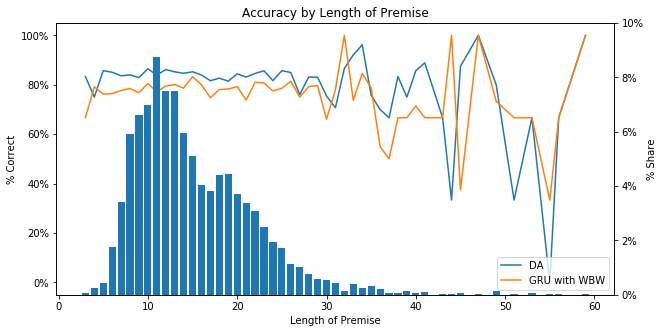

In [365]:
f, (ax1) = plt.subplots(1, 1,figsize=(10,5))
ax1.plot(da_by_p_len.index,da_by_p_len['pct_corr'],label='DA')
ax1.plot(gru_by_p_len.index,gru_by_p_len['pct_corr'],label='GRU with WBW')
ax2 = ax1.twinx()
ax2.set_ylim(ymax=.1)
ax2.bar(da_by_p_len.index,da_by_p_len['share'])
#ax1.hist(da_wrong['len_p'],bins=30)
#ax2.hist(da_wrong['len_diff'],bins=30)
for ax in [ax1,ax2]:
    vals = ax.get_yticks()
    ax.set_yticklabels(['{0:.0f}%'.format(x*100) for x in vals])
ax1.set_ylabel('% Correct')
ax1.set_xlabel('Length of Premise')
ax2.set_ylabel('% Share')
ax1.set_title('Accuracy by Length of Premise')
ax1.legend(loc='lower right')
plt.show()

In [366]:
#group by hypothesis len
da_by_h_len = df.groupby('len_h')['da_corr','da_wrong'].sum()
da_by_h_len['total'] = da_by_h_len['da_corr']+da_by_h_len['da_wrong']
da_by_h_len['share'] = da_by_h_len['total']/da_by_h_len['total'].sum()
da_by_h_len['pct_corr'] = da_by_h_len['da_corr']/(da_by_h_len['total'])

gru_by_h_len = df.groupby('len_h')['gru_corr','gru_wrong'].sum()
gru_by_h_len['total'] = gru_by_h_len['gru_corr']+gru_by_h_len['gru_wrong']
gru_by_h_len['share'] = gru_by_h_len['total']/gru_by_h_len['total'].sum()
gru_by_h_len['pct_corr'] = gru_by_h_len['gru_corr']/(gru_by_h_len['total'])

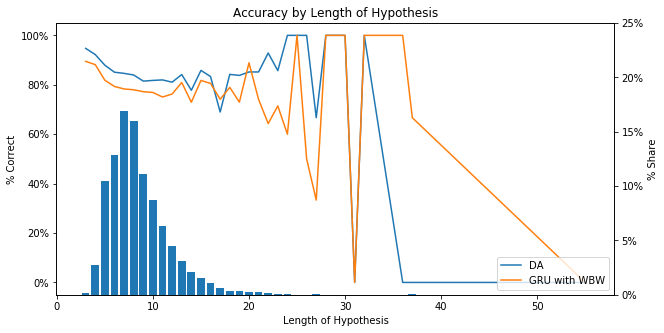

In [367]:
f, (ax1) = plt.subplots(1, 1,figsize=(10,5))
ax1.plot(da_by_h_len.index,da_by_h_len['pct_corr'],label='DA')
ax1.plot(gru_by_h_len.index,gru_by_h_len['pct_corr'],label='GRU with WBW')
ax2 = ax1.twinx()
ax2.set_ylim(ymax=.25)
ax2.bar(gru_by_h_len.index,gru_by_h_len['share'])
#ax1.hist(da_wrong['len_p'],bins=30)
#ax2.hist(da_wrong['len_diff'],bins=30)
for ax in [ax1,ax2]:
    vals = ax.get_yticks()
    ax.set_yticklabels(['{0:.0f}%'.format(x*100) for x in vals])
ax1.set_ylabel('% Correct')
ax1.set_xlabel('Length of Hypothesis')
ax2.set_ylabel('% Share')
ax1.set_title('Accuracy by Length of Hypothesis')
ax1.legend(loc='lower right')
plt.show()

In [368]:
#group by len diff
da_by_p_len = df.groupby('len_diff')['da_corr','da_wrong'].sum()
da_by_p_len['total'] = da_by_p_len['da_corr']+da_by_p_len['da_wrong']
da_by_p_len['share'] = da_by_p_len['total']/da_by_p_len['total'].sum()
da_by_p_len['pct_corr'] = da_by_p_len['da_corr']/(da_by_p_len['total'])

gru_by_p_len = df.groupby('len_diff')['gru_corr','gru_wrong'].sum()
gru_by_p_len['total'] = gru_by_p_len['gru_corr']+gru_by_p_len['gru_wrong']
gru_by_p_len['share'] = gru_by_p_len['total']/gru_by_p_len['total'].sum()
gru_by_p_len['pct_corr'] = gru_by_p_len['gru_corr']/(gru_by_p_len['total'])

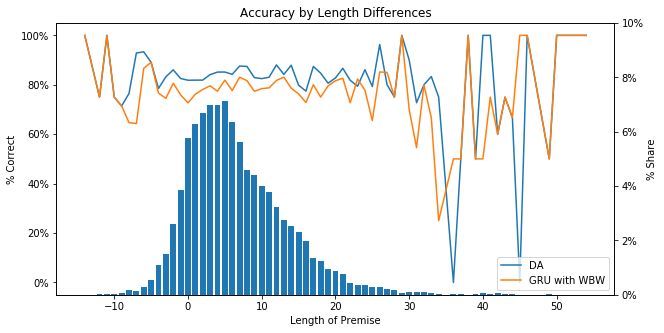

In [369]:
f, (ax1) = plt.subplots(1, 1,figsize=(10,5))
ax1.plot(da_by_p_len.index,da_by_p_len['pct_corr'],label='DA')
ax1.plot(gru_by_p_len.index,gru_by_p_len['pct_corr'],label='GRU with WBW')
ax2 = ax1.twinx()
ax2.set_ylim(ymax=.1)
ax2.bar(da_by_p_len.index,da_by_p_len['share'])
#ax1.hist(da_wrong['len_p'],bins=30)
#ax2.hist(da_wrong['len_diff'],bins=30)
for ax in [ax1,ax2]:
    vals = ax.get_yticks()
    ax.set_yticklabels(['{0:.0f}%'.format(x*100) for x in vals])
ax1.set_ylabel('% Correct')
ax1.set_xlabel('Length of Premise')
ax2.set_ylabel('% Share')
ax1.set_title('Accuracy by Length Differences')
ax1.legend(loc='lower right')
plt.show()

In [370]:
#group by abs len diff
df['abs_diff'] = abs(df['len_diff'])
da_by_p_len = df.groupby('abs_diff')['da_corr','da_wrong'].sum()
da_by_p_len['total'] = da_by_p_len['da_corr']+da_by_p_len['da_wrong']
da_by_p_len['share'] = da_by_p_len['total']/da_by_p_len['total'].sum()
da_by_p_len['pct_corr'] = da_by_p_len['da_corr']/(da_by_p_len['total'])

gru_by_p_len = df.groupby('abs_diff')['gru_corr','gru_wrong'].sum()
gru_by_p_len['total'] = gru_by_p_len['gru_corr']+gru_by_p_len['gru_wrong']
gru_by_p_len['share'] = gru_by_p_len['total']/gru_by_p_len['total'].sum()
gru_by_p_len['pct_corr'] = gru_by_p_len['gru_corr']/(gru_by_p_len['total'])

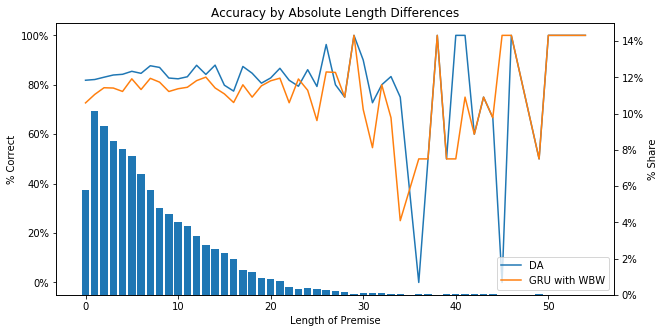

In [371]:
f, (ax1) = plt.subplots(1, 1,figsize=(10,5))
ax1.plot(da_by_p_len.index,da_by_p_len['pct_corr'],label='DA')
ax1.plot(gru_by_p_len.index,gru_by_p_len['pct_corr'],label='GRU with WBW')
ax2 = ax1.twinx()
ax2.set_ylim(ymax=.15)
ax2.bar(da_by_p_len.index,da_by_p_len['share'])
#ax1.hist(da_wrong['len_p'],bins=30)
#ax2.hist(da_wrong['len_diff'],bins=30)
for ax in [ax1,ax2]:
    vals = ax.get_yticks()
    ax.set_yticklabels(['{0:.0f}%'.format(x*100) for x in vals])
ax1.set_ylabel('% Correct')
ax1.set_xlabel('Length of Premise')
ax2.set_ylabel('% Share')
ax1.set_title('Accuracy by Absolute Length Differences')
ax1.legend(loc='lower right')
plt.show()

# Cumulative accuracy by length

In [372]:
#group by premise len
da_by_p_len = df.groupby('len_p')['da_corr','da_wrong'].sum()
total= da_by_p_len['da_corr']+da_by_p_len['da_wrong']
da_by_p_len=da_by_p_len.cumsum()
da_by_p_len['total'] = total
da_by_p_len['cum_total'] = da_by_p_len['da_corr']+da_by_p_len['da_wrong']
da_by_p_len['share'] = da_by_p_len['total']/da_by_p_len['total'].sum()
da_by_p_len['pct_corr'] = da_by_p_len['da_corr']/(da_by_p_len['cum_total'])

gru_by_p_len = df.groupby('len_p')['gru_corr','gru_wrong'].sum()
gru_by_p_len=gru_by_p_len.cumsum()
gru_by_p_len['total'] = total
gru_by_p_len['cum_total'] = gru_by_p_len['gru_corr']+gru_by_p_len['gru_wrong']
gru_by_p_len['share'] = gru_by_p_len['total']/gru_by_p_len['total'].sum()
gru_by_p_len['pct_corr'] = gru_by_p_len['gru_corr']/(gru_by_p_len['cum_total'])

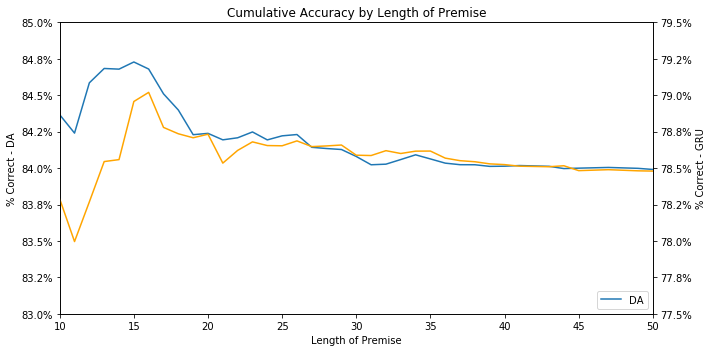

In [373]:
f, (ax1) = plt.subplots(1, 1,figsize=(10,5))
ax1.plot(da_by_p_len.index,da_by_p_len['pct_corr'],label='DA')

ax1.set_xlim((10,50))
ax1.set_ylim((.83,.85))
ax2 = ax1.twinx()
ax2.set_ylim((.775,.795))
ax2.plot(gru_by_p_len.index,gru_by_p_len['pct_corr'],label='GRU with WBW',c='orange')
#ax2.set_ylim(ymax=.1)
#ax2.bar(da_by_p_len.index,da_by_p_len['share'])
#ax1.hist(da_wrong['len_p'],bins=30)
#ax2.hist(da_wrong['len_diff'],bins=30)
for ax in [ax1,ax2]:
    vals = ax.get_yticks()
    ax.set_yticklabels(['{0:.1f}%'.format(x*100) for x in vals])
ax1.set_ylabel('% Correct - DA')
ax1.set_xlabel('Length of Premise')
ax2.set_ylabel('% Correct - GRU')
ax1.set_title('Cumulative Accuracy by Length of Premise')
ax1.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Negation

In [374]:
df['h_negate']=np.where(df['hypothesis'].str.contains('not'),1,0)
df['p_negate']=np.where(df['premise'].str.contains('not'),1,0)

In [375]:
df['h_negate'].sum()

137

In [376]:
df['p_negate'].sum()

314

In [377]:
acc = df[df['h_negate']==1]['da_corr'].sum()/float(df['h_negate'].sum())
print('DA accuracy with negation in hypothesis: {:.1%} \n'.format(acc))

acc = df[df['h_negate']==0]['da_corr'].sum()/float(df[df['h_negate']==0].shape[0])
print('DA accuracy without negation in hypothesis: {:.1%} \n'.format(acc))

acc =df[df['p_negate']==1]['da_corr'].sum()/float(df['p_negate'].sum())
print('DA accuracy with negation in premise: {:.1%} \n'.format(acc))

acc =df[df['p_negate']==0]['da_corr'].sum()/float(df[df['p_negate']==0].shape[0])
print('DA accuracy without negation in premise: {:.1%} \n'.format(acc))

DA accuracy with negation in hypothesis: 78.1% 

DA accuracy without negation in hypothesis: 84.0% 

DA accuracy with negation in premise: 80.9% 

DA accuracy without negation in premise: 84.0% 



In [378]:
acc = df[df['h_negate']==1]['gru_corr'].sum()/float(df['h_negate'].sum())
print('GRU accuracy with negation in hypothesis: {:.1%} \n'.format(acc))

acc = df[df['h_negate']==0]['gru_corr'].sum()/float(df[df['h_negate']==0].shape[0])
print('GRU accuracy without negation in hypothesis: {:.1%} \n'.format(acc))

acc = df[df['p_negate']==1]['gru_corr'].sum()/float(df['p_negate'].sum())
print('GRU accuracy with negation in premise: {:.1%} \n'.format(acc))

acc =df[df['p_negate']==0]['gru_corr'].sum()/float(df[df['p_negate']==0].shape[0])
print('GRU accuracy without negation in premise: {:.1%} \n'.format(acc))

GRU accuracy with negation in hypothesis: 70.1% 

GRU accuracy without negation in hypothesis: 78.6% 

GRU accuracy with negation in premise: 77.7% 

GRU accuracy without negation in premise: 78.5% 



In [379]:
from statsmodels.stats.proportion import proportions_ztest

In [380]:
def twoSampZ(X1, X2, mudiff,n1, n2):
    from numpy import sqrt, abs, round
    from scipy.stats import norm
    p_star = (X1+X2)/(n1+n2)
    pooledSE = sqrt(p_star*(1-p_star)*(1/n1+1/n2))
    z = ((X1/n1 - X2/n2) - mudiff)/pooledSE
    pval = 2*(1 - norm.cdf(abs(z)))
    #divide pval by two to get single tail pval
    pval=pval/2
    return round(z, 3), round(pval, 4)

In [381]:
_,p_val = twoSampZ(df[df['h_negate']==1]['da_corr'].sum(),df[df['h_negate']==0]['da_corr'].sum(),\
         0,\
        float(df['h_negate'].sum()),float(df[df['h_negate']==0].shape[0]))
print('P-value for difference in DA accuracy with negation in hypothesis: {:.1%} \n'.format(p_val))

_,p_val = twoSampZ(df[df['p_negate']==1]['da_corr'].sum(),df[df['p_negate']==0]['da_corr'].sum(),\
         0,\
        float(df['p_negate'].sum()),float(df[df['p_negate']==0].shape[0]))
print('P-value for difference in DA accuracy with negation in premise: {:.1%} \n'.format(p_val))

P-value for difference in DA accuracy with negation in hypothesis: 3.0% 

P-value for difference in DA accuracy with negation in premise: 6.7% 



In [382]:
_,p_val = twoSampZ(df[df['h_negate']==1]['gru_corr'].sum(),df[df['h_negate']==0]['gru_corr'].sum(),\
         0,\
        float(df['h_negate'].sum()),float(df[df['h_negate']==0].shape[0]))
print('P-value for difference in GRU accuracy with negation in hypothesis: {:.1%} \n'.format(p_val))

_,p_val = twoSampZ(df[df['p_negate']==1]['gru_corr'].sum(),df[df['p_negate']==0]['gru_corr'].sum(),\
         0,\
        float(df['p_negate'].sum()),float(df[df['p_negate']==0].shape[0]))
print('P-value for difference in GRU accuracy with negation in premise: {:.1%} \n'.format(p_val))

P-value for difference in GRU accuracy with negation in hypothesis: 0.8% 

P-value for difference in GRU accuracy with negation in premise: 37.1% 



In [355]:
df[np.where((df['hypothesis'].str.contains('four')&\
             ~df['premise'].str.contains('four'))\
            ,True,False)][['pred_y_da','pred_y_gru','true_y','premise','hypothesis']]

,pred_y_da,pred_y_gru,true_y,premise,hypothesis
5,1,1,0,<s> trucks racing,<s> four trucks are racing against each other ...
27,0,0,0,<s> a skateboarder <oov69>,<s> someone is on a board with four wheels
2396,2,2,2,<s> a man riding a dirt bike on a racetrack,<s> a man is riding a four-wheeler on his farm
2947,2,1,2,<s> dog standing with 1 foot up in a large field,<s> the dog is on all fours running
5226,2,2,2,<s> a young boy wearing safety swimming gear a...,<s> a family of four plays in the surf
5980,0,0,0,<s> three men playing cricket wearing all whit...,<s> four men are playing cricket
6098,1,1,1,<s> three adults and one child are waiting out...,<s> four people are waiting for the bus
6199,0,0,0,<s> three adults and one child are waiting out...,<s> four people are standing in front of a bui...
6253,2,2,2,<s> three men playing cricket wearing all whit...,<s> four men are walking to the store in new j...
6512,0,0,0,<s> three adult bystanders and one child looki...,<s> four people are looking at the sky


In [348]:
np.where(df['premise'].str.contains('two'),True,False)

array([False, False, False, ...,  True, False, False], dtype=bool)